**Problem statement:** Farmers who grow potatoes are facing lot of economic losses every year beacause of various diseases that can happen to a potato plant .There are two common diseases known as early blight and late blight . Early blight is caused by a fungus and late blight is caused by a specific microorganism and if farmer can detect these diseases early and apply appropriate treatment then it can save lot of waste and prevent the economic loss.The treatments for early blight and late blight are little different so it's important that you accurately identify what kind of disease is there in that potato plant.AtliQ Agriculture is an AI company that happens to solve problems in agriculture domain and that company has taken this project and they have decided to build a mobile application which they can give it to a farmer and farmer all they need to do is go to their farm and just take a picture of the plant and the mobile application will tell them whether the potato plant is healthy or it has one of these diseases and behind the scene it will be using deep learning and CNN .  

Data augmentation because we might not have enough diverse set of images so we need to rotate and flip and adjust contrast to create more training samples


Quantization is a way to reduce size of model sothat model will occupy less memory and deploy easily

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL


In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset=tf.keras.preprocessing .image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2182 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
len(dataset)

# length is 69  , since batch size is 32(one batch is 32 images)
#so 69*32=2208 images

69

(32, 256, 256, 3)
[0 0 1 1 1 1 0 1 1 0 2 2 1 1 1 1 0 0 0 1 2 0 1 2 1 0 0 1 1 1 0 0]
tf.Tensor(
[[[206. 204. 209.]
  [203. 201. 206.]
  [198. 196. 201.]
  ...
  [188. 187. 195.]
  [186. 185. 193.]
  [185. 184. 192.]]

 [[212. 210. 215.]
  [207. 205. 210.]
  [201. 199. 204.]
  ...
  [191. 190. 198.]
  [192. 191. 199.]
  [194. 193. 201.]]

 [[206. 204. 209.]
  [202. 200. 205.]
  [198. 196. 201.]
  ...
  [189. 188. 196.]
  [194. 193. 201.]
  [198. 197. 205.]]

 ...

 [[168. 163. 169.]
  [114. 109. 115.]
  [129. 124. 130.]
  ...
  [132. 126. 136.]
  [137. 131. 141.]
  [119. 113. 123.]]

 [[141. 136. 142.]
  [153. 148. 154.]
  [127. 122. 128.]
  ...
  [107. 101. 111.]
  [114. 108. 118.]
  [157. 151. 161.]]

 [[149. 144. 150.]
  [183. 178. 184.]
  [145. 140. 146.]
  ...
  [138. 132. 142.]
  [138. 132. 142.]
  [147. 141. 151.]]], shape=(256, 256, 3), dtype=float32)
[[[206. 204. 209.]
  [203. 201. 206.]
  [198. 196. 201.]
  ...
  [188. 187. 195.]
  [186. 185. 193.]
  [185. 184. 192.]]

 [[212. 

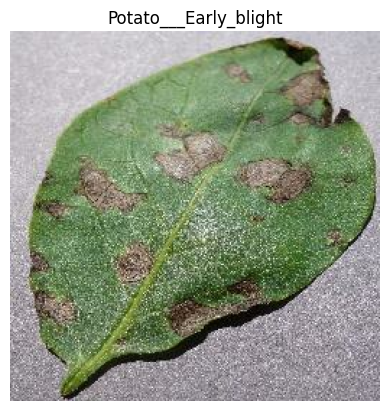

In [ ]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())  #since every element get is tensor so convert that to numpy()
  print(image_batch[0])  # print first image , its a tensor
  print(image_batch[0].numpy())#convert tensor to numpy,every number is 0 to 255
  print(image_batch[0].shape)#shape of first image

  plt.imshow(image_batch[0].numpy().astype("uint8"))#plot first image
  plt.title(class_names[label_batch[0]])
  plt.axis("off")#to remove axis numbers
  plt.show()



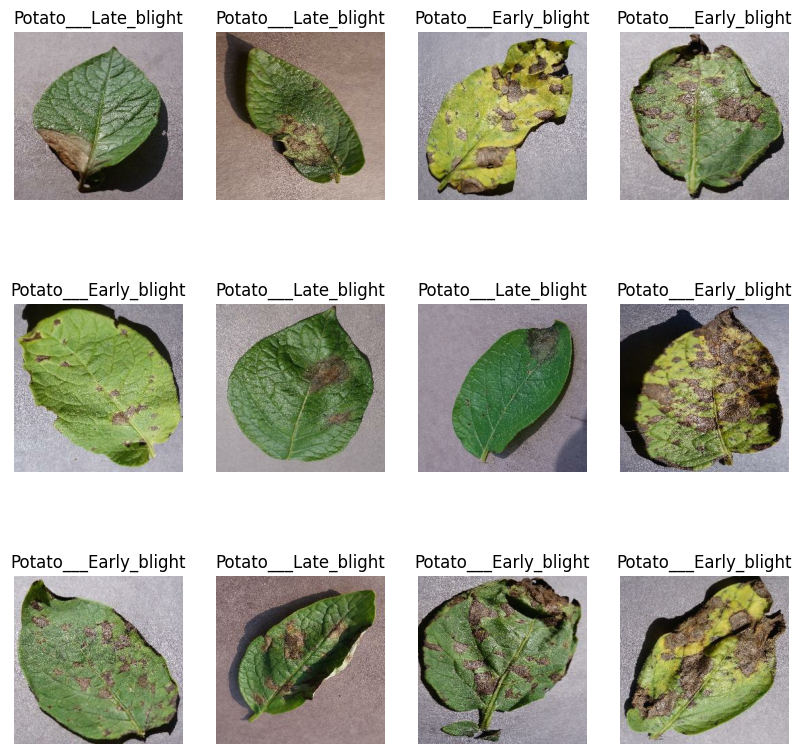

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

split dataset

80% --> training
20% ---> for 10% validation ,10% testing

once we have done 50 epochs then ,once we have final model then we use this 10% testing dataset to measure the accuracy of our model

In [ ]:
len(dataset)

69

In [ ]:
train_size=0.8
len(dataset)*train_size
#what is 80% of 69 is 55.2

55.2

In [ ]:
#so take first 55 samples ,actually take first 55 batches

train_ds=dataset.take(55)
len(train_ds)

55

In [ ]:
test_ds=dataset.skip(55)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.9

In [ ]:
#so need 6 samples for test dataset

val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

or we can split like this:

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = ds.cardinality().numpy()  # Get dataset size correctly

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Correct dataset splitting
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)  # Using integer sum correctly

    return train_ds, val_ds, test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)  , len(val_ds) , len(test_ds)

(55, 6, 8)

perfetch - if we are using cpu or gpu, if gpu is busy in training the prefetch will load the next set of batch from your disk and that will improve the performance

train_ds.cache()->    this will read the image from disk and then for the next iteration when we need this same image it will keep that image in the memory so this improves the performance of pipeline

In [ ]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Preprocessing** :

Now , we creating some layers for preprocessing.

n_classes = 3

means your model is performing multi-class classification with 3 different categories (labels).

It is used in the output layer of our model.

Dense(n_classes) → Creates n_classes output neurons (one for each class).

activation='softmax' → Converts outputs into probabilities for each class.

In [ ]:
IMAGE_SIZE = 250
BATCH_SIZE = 2
CHANNELS = 3
n_classes = 3


In [ ]:

#it will resize image by 250/250   this resize and rescale layer will eventually go to the our ultimate model and when we have our train model and starts predicting .During prediction if you are supplying an image which is not 250/250 i.e will have some different dimensions so this will take care of resizing it
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data augmentation to address overfitting

if someone gives the rotated image of same image

do some RandomFlip

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Remove "experimental.preprocessing"
    layers.RandomRotation(0.2)
])

Build CNN model

**layers.Conv2D(32, (3,3), activation='relu')**

Here, parameters

**(a.) 32 → Number of Filters (Feature Maps)**
The first parameter (32) represents the number of filters (also called kernels).

32 filters → Detects 32 different features
64 filters → Detects 64 different features

**(b.)(3,3) → Kernel Size (Filter Size)**
The second parameter (3,3) defines the height and width of each filter (also called the kernel).
A (3,3) filter means that each filter will scan a 3×3 region of the input image at a time.

*Common kernel sizes:*

(3,3): Standard choice for most CNNs (small, captures local patterns)

(5,5): Slightly larger receptive field

(7,7): Used in deeper networks


**(c.)activation='relu' → Activation Function.**

It helps the network learn complex features.
Prevents the vanishing gradient problem (better training stability).
Faster computation compared to sigmoid/tanh.

In [ ]:


# This is model architecture
model=models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 59, 59, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,459 (669.76 KB)

 Trainable params: 171,459 (669.76 KB)

 Non-trainable params: 0 (0.00 B)

**model.compile() is a function in Keras is used to configure the model before training.It is needed to define how the model learns by specifying:**


Optimizer → Updates weights to minimize errors

Loss function → Measures model errors
Metrics → Tracks performance

*Without it, the model won't know how to train or learn properly.*

**optimizer='adam' → Optimizer**

The optimizer updates the weights of the model to minimize loss.

**loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)** → Loss Function


The loss function measures how well the model is performing.

SparseCategoricalCrossentropy is used for multi-class classification when labels are integers (not one-hot encoded).


*Why from_logits=False?*


If from_logits=True: The model outputs raw logits (values before applying softmax).


If from_logits=False: The model outputs probabilities (softmax applied).


Since our last layer has activation='softmax', we should use from_logits=False.

**metrics=['accuracy'] → Evaluation Metric**

metrics=['accuracy'] means the model will track accuracy during training.
Accuracy measures the percentage of correctly classified samples.

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.4768 - loss: 0.9295 - val_accuracy: 0.5573 - val_loss: 0.8084
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.5876 - loss: 0.8040 - val_accuracy: 0.7865 - val_loss: 0.5277
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.7469 - loss: 0.5987 - val_accuracy: 0.7865 - val_loss: 0.5436
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.7858 - loss: 0.4774 - val_accuracy: 0.8281 - val_loss: 0.4129
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.8423 - loss: 0.3722 - val_accuracy: 0.8802 - val_loss: 0.3223
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8131 - loss: 0.3897 - val_accuracy: 0.8594 - val_loss: 0.3586
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.8633 - loss: 0.3513 - val_accuracy: 0.9427 - val_loss: 0.1730
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.9296 - loss: 0.1804 - val_accuracy: 0.9583 - v

In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
scores

tensorflow Keras callback history

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
#is a python list
len(history.history['accuracy']) # gives 50 values
history.history['accuracy']

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Plot training and validation accuracy

In [ ]:
#Plot for accuracy chart
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



# plot for loss chart
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_acc,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Makes Predictions

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8')) # this will show the actual image

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction=model.predict(images_batch)# This is for the prediction for 32 images
  print(batch_prediction[0])
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0) # create a batch

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

In [ ]:
# lets do prediction for 9 images
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

    plt.axis('off')

In [ ]:
#model_version=2
#model.save(f"/content/drive/MyDrive/models/{model_version}")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/models") + [0]])+1
model.save(f"/content/drive/MyDrive/models/{model_version}")